--- ETAP 1: Głęboka analiza plików audio ---
 -> Przetwarzanie clapping (103 plików)...
 -> Przetwarzanie footsteps (100 plików)...
 -> Przetwarzanie doorbell (100 plików)...


/home/muzykos-laptop/Documents/GIThub/Projekt_badawczy_System_rozpoznawania_zdarzen_dzwiekowych_w_przestrzeni_domowej-main/.venv/lib/python3.13/site-packages/librosa/feature/spectral.py:2148: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


 -> Przetwarzanie vacuum_cleaner (100 plików)...
 -> Przetwarzanie faucet (100 plików)...
 -> Przetwarzanie hairdryer (97 plików)...
 -> Przetwarzanie door_knock (100 plików)...

--- ETAP 2: Testowanie wpływu n_mfcc (z pełnym zestawem cech dodatkowych) ---
Skład wektora w każdej iteracji: [6x n_mfcc] + [6 cech spektralnych]
[ 0.5%] n_mfcc:  1 | Rozmiar wektora:  12 | Acc: 70.5628%
[ 1.0%] n_mfcc:  2 | Rozmiar wektora:  18 | Acc: 76.1905%
[ 1.5%] n_mfcc:  3 | Rozmiar wektora:  24 | Acc: 78.3550%
[ 2.0%] n_mfcc:  4 | Rozmiar wektora:  30 | Acc: 76.1905%
[ 2.5%] n_mfcc:  5 | Rozmiar wektora:  36 | Acc: 79.6537%
[ 3.0%] n_mfcc:  6 | Rozmiar wektora:  42 | Acc: 79.6537%
[ 3.5%] n_mfcc:  7 | Rozmiar wektora:  48 | Acc: 80.0866%
[ 4.0%] n_mfcc:  8 | Rozmiar wektora:  54 | Acc: 80.0866%
[ 4.5%] n_mfcc:  9 | Rozmiar wektora:  60 | Acc: 79.6537%
[ 5.0%] n_mfcc: 10 | Rozmiar wektora:  66 | Acc: 80.5195%
[ 5.5%] n_mfcc: 11 | Rozmiar wektora:  72 | Acc: 81.8182%
[ 6.0%] n_mfcc: 12 | Rozmiar wektora

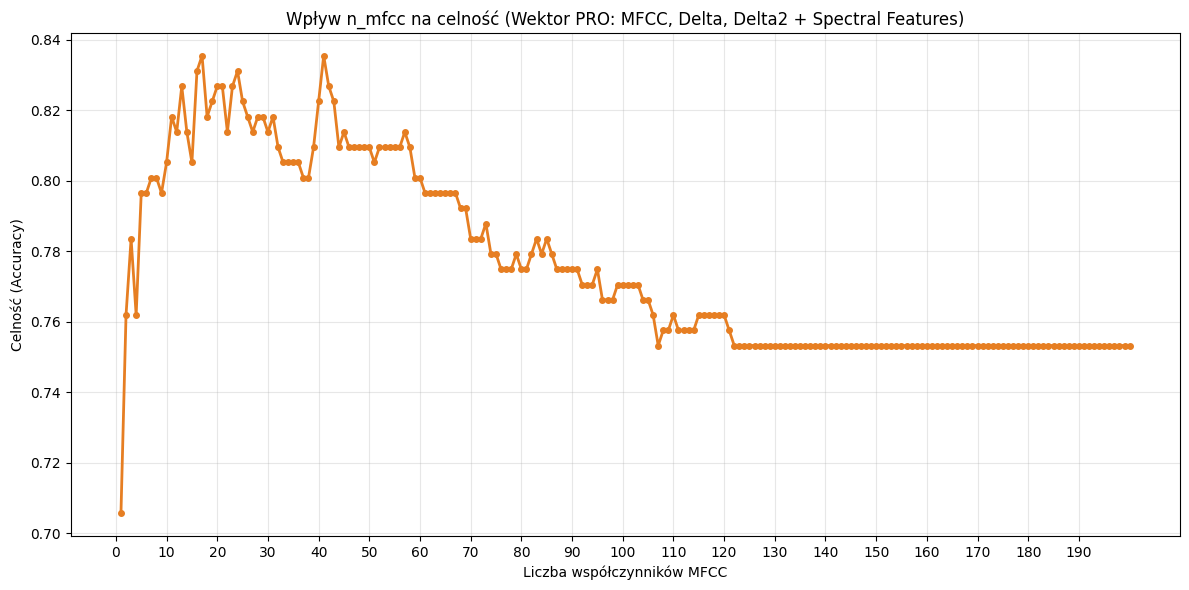

In [3]:
import os
import librosa
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.pipeline import make_pipeline

from sklearn.inspection import permutation_importance
import pandas as pd



# Wywołanie (po treningu modelu):
# importance_results = plot_feature_importance(model, X_test, y_test, n_mfcc=13)

# ==========================================
# KONFIGURACJA
# ==========================================
DATA_DIR = '../../dataset/'  
MAX_MFCC = 200                 
RANDOM_STATE = 42             
TEST_SIZE = 0.33              

def extract_all_base_features(file_path, max_n):
    """
    Ekstrahuje wszystko co możliwe z pliku raz, 
    aby nie powtarzać ciężkich obliczeń w pętli.
    """
    y, sr = librosa.load(file_path, sr=None)
    
    # 1. MFCC i pochodne (zależne od n_mfcc)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=max_n)
    delta = librosa.feature.delta(mfcc)
    delta2 = librosa.feature.delta(mfcc, order=2) # Delta-Delta (Przyspieszenie)
    
    # 2. Cechy spektralne (niezależne od n_mfcc)
    cent = librosa.feature.spectral_centroid(y=y, sr=sr)
    roll = librosa.feature.spectral_rolloff(y=y, sr=sr)
    zcr = librosa.feature.zero_crossing_rate(y)
    
    # Statystyki dla cech stałych (wyliczamy raz)
    fixed_stats = np.array([
        np.mean(cent), np.std(cent),
        np.mean(roll), np.std(roll),
        np.mean(zcr),  np.std(zcr)
    ])
    
    return {
        'mfcc': mfcc,
        'delta': delta,
        'delta2': delta2,
        'fixed_features': fixed_stats
    }

def main():
    start_total = time.time()
    
    # --- ETAP 1: Ładowanie i wstępna ekstrakcja ---
    raw_data = []
    labels_raw = []
    
    classes = [d for d in os.listdir(DATA_DIR) if os.path.isdir(os.path.join(DATA_DIR, d))]
    print(f"--- ETAP 1: Głęboka analiza plików audio ---")
    
    for label in classes:
        class_path = os.path.join(DATA_DIR, label)
        files = [f for f in os.listdir(class_path) if f.endswith('.wav')]
        print(f" -> Przetwarzanie {label} ({len(files)} plików)...")
        
        for filename in files:
            try:
                res = extract_all_base_features(os.path.join(class_path, filename), MAX_MFCC)
                raw_data.append(res)
                labels_raw.append(label)
            except Exception as e:
                print(f" ! Błąd w {filename}: {e}")

    le = LabelEncoder()
    y = le.fit_transform(labels_raw)
    
    # --- ETAP 2: Pętla testowa n_mfcc ---
    n_range = range(1, MAX_MFCC + 1)
    accuracies = []
    
    print("\n--- ETAP 2: Testowanie wpływu n_mfcc (z pełnym zestawem cech dodatkowych) ---")
    print(f"Skład wektora w każdej iteracji: [6x n_mfcc] + [6 cech spektralnych]")
    
    for n in n_range:
        loop_start = time.time()
        X = []
        
        for item in raw_data:
            # Wycinamy fragmenty MFCC/Delta/Delta2 dla bieżącego n
            m = item['mfcc'][:n, :]
            d = item['delta'][:n, :]
            d2 = item['delta2'][:n, :]
            
            # Budujemy wektor: statystyki MFCC + statystyki spektralne
            vector = np.concatenate([
                np.mean(m, axis=1), np.std(m, axis=1),   # MFCC
                np.mean(d, axis=1), np.std(d, axis=1),   # Delta
                np.mean(d2, axis=1), np.std(d2, axis=1), # Delta-Delta
                item['fixed_features']                   # Centroid, Rolloff, ZCR
            ])
            X.append(vector)
            
        X = np.array(X)
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y
        )
        
        # Model
        model = make_pipeline(StandardScaler(), SVC(kernel="rbf", C=1.0))
        model.fit(X_train, y_train)
        
        acc = accuracy_score(y_test, model.predict(X_test))
        accuracies.append(acc)
        
        # Echo postępu
        progress = (n / MAX_MFCC) * 100
        print(f"[{progress:4.1f}%] n_mfcc: {n:2d} | Rozmiar wektora: {len(X[0]):3d} | Acc: {acc:.4%}")

    # --- ETAP 3: Wyniki ---
    print(f"\nGotowe! Całkowity czas: {time.time() - start_total:.2f}s")
    
    plt.figure(figsize=(12, 6))
    plt.plot(n_range, accuracies, marker='o', color='#e67e22', linewidth=2, markersize=4)
    plt.title('Wpływ n_mfcc na celność (Wektor PRO: MFCC, Delta, Delta2 + Spectral Features)')
    plt.xlabel('Liczba współczynników MFCC')
    plt.ylabel('Celność (Accuracy)')
    plt.grid(True, alpha=0.3)
    plt.xticks(np.arange(0, MAX_MFCC, 10))
    plt.tight_layout()
    plt.show()

def plot_feature_importance(model, X_test, y_test, n_mfcc):
    # 1. Generowanie nazw cech dla wektora PRO
    feature_names = []
    for suffix in ["Mean", "Std"]:
        feature_names += [f"MFCC_{i}_{suffix}" for i in range(1, n_mfcc + 1)]
    for suffix in ["Mean", "Std"]:
        feature_names += [f"Delta_{i}_{suffix}" for i in range(1, n_mfcc + 1)]
    for suffix in ["Mean", "Std"]:
        feature_names += [f"Delta2_{i}_{suffix}" for i in range(1, n_mfcc + 1)]
    
    feature_names += ["Centroid_Mean", "Centroid_Std", "Rolloff_Mean", "Rolloff_Std", "ZCR_Mean", "ZCR_Std"]

    # 2. Obliczanie ważności (permutation importance)
    print("\nObliczanie rankingu ważności cech (może to chwilę potrwać)...")
    result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)
    
    # 3. Sortowanie i wizualizacja
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': result.importances_mean,
        'Std': result.importances_std
    }).sort_values(by='Importance', ascending=False)

    # Pokazujemy top 20 najważniejszych cech
    top_20 = importance_df.head(20)
    
    plt.figure(figsize=(10, 8))
    plt.barh(top_20['Feature'], top_20['Importance'], xerr=top_20['Std'], color='skyblue')
    plt.gca().invert_yaxis()
    plt.title("Top 20 najważniejszych cech (Permutation Importance)")
    plt.xlabel("Spadek celności modelu po usunięciu cechy")
    plt.tight_layout()
    plt.show()

    return importance_df

if __name__ == "__main__":
    main()

Przetwarzanie klas: ['clapping', 'footsteps', 'doorbell', 'vacuum_cleaner', 'faucet', 'hairdryer', 'door_knock']


/home/muzykos-laptop/Documents/GIThub/Projekt_badawczy_System_rozpoznawania_zdarzen_dzwiekowych_w_przestrzeni_domowej-main/.venv/lib/python3.13/site-packages/librosa/feature/spectral.py:2148: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Wykryto 84 cech. Generowanie 5 wykresów...


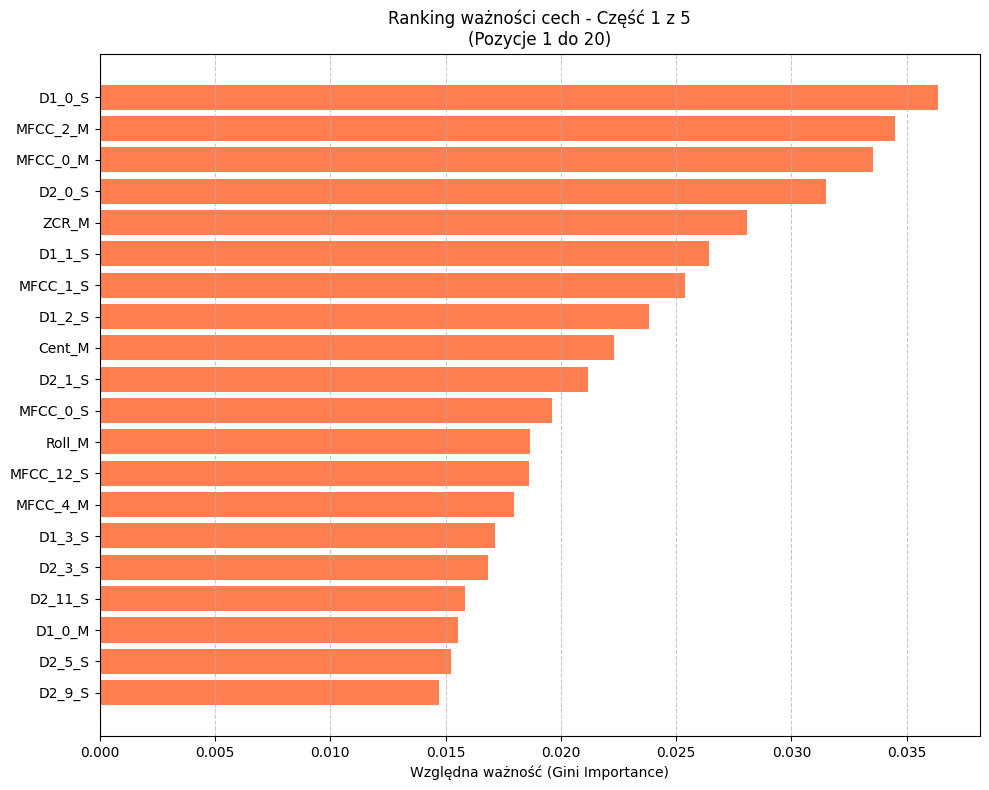

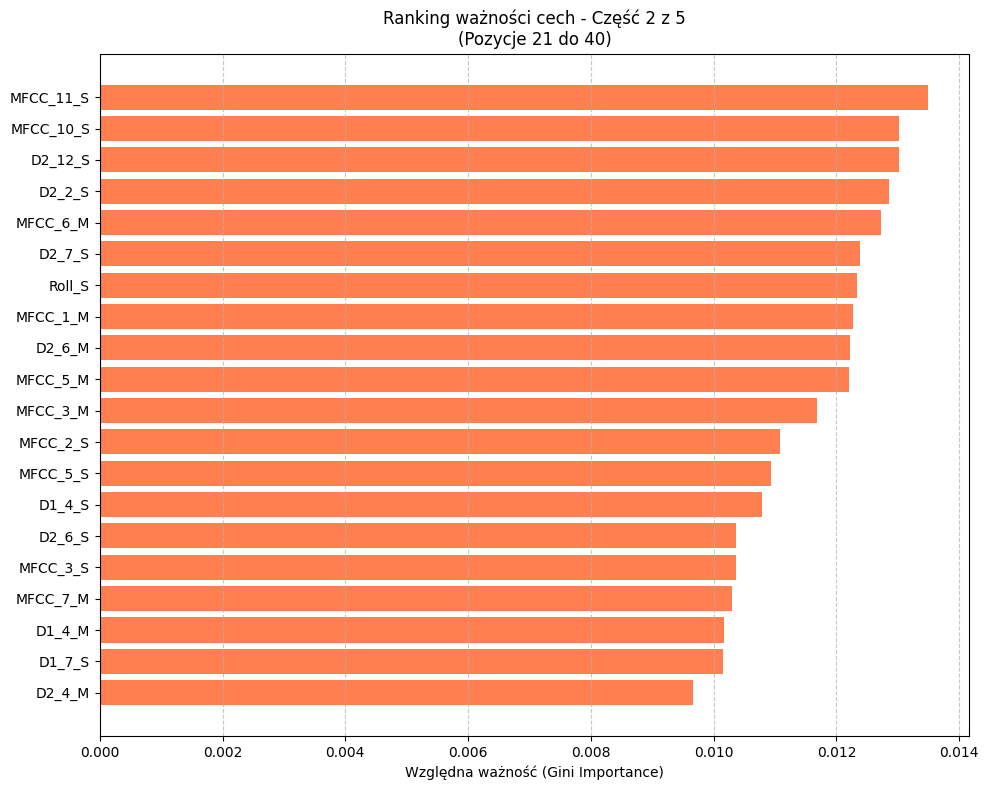

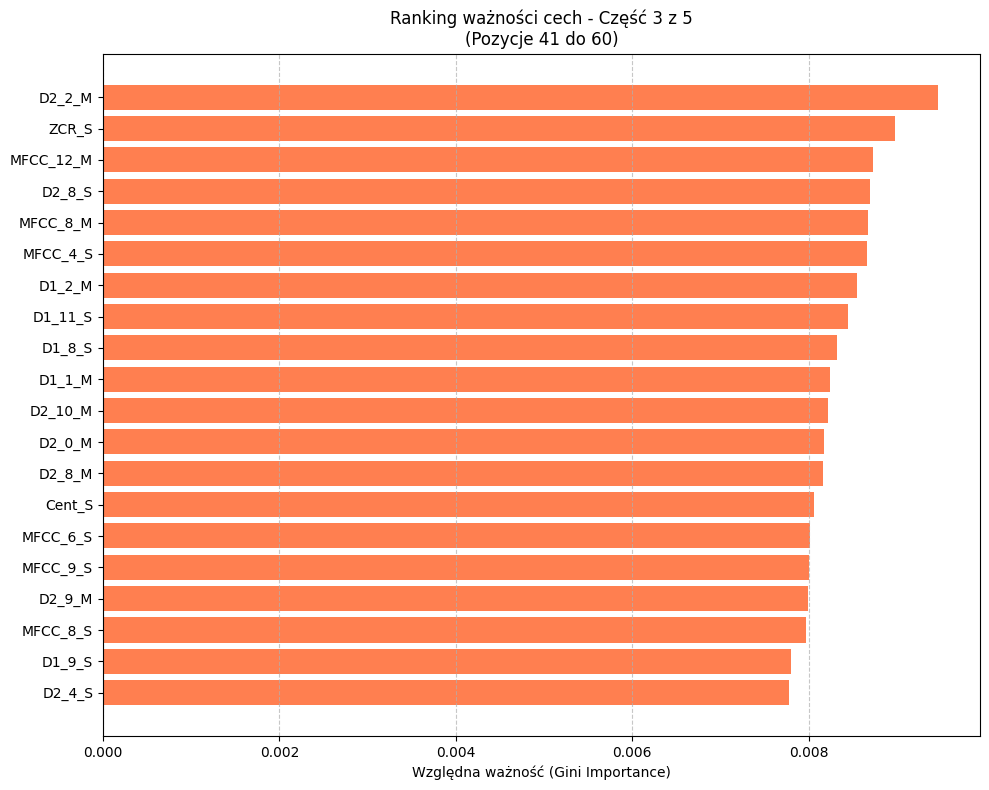

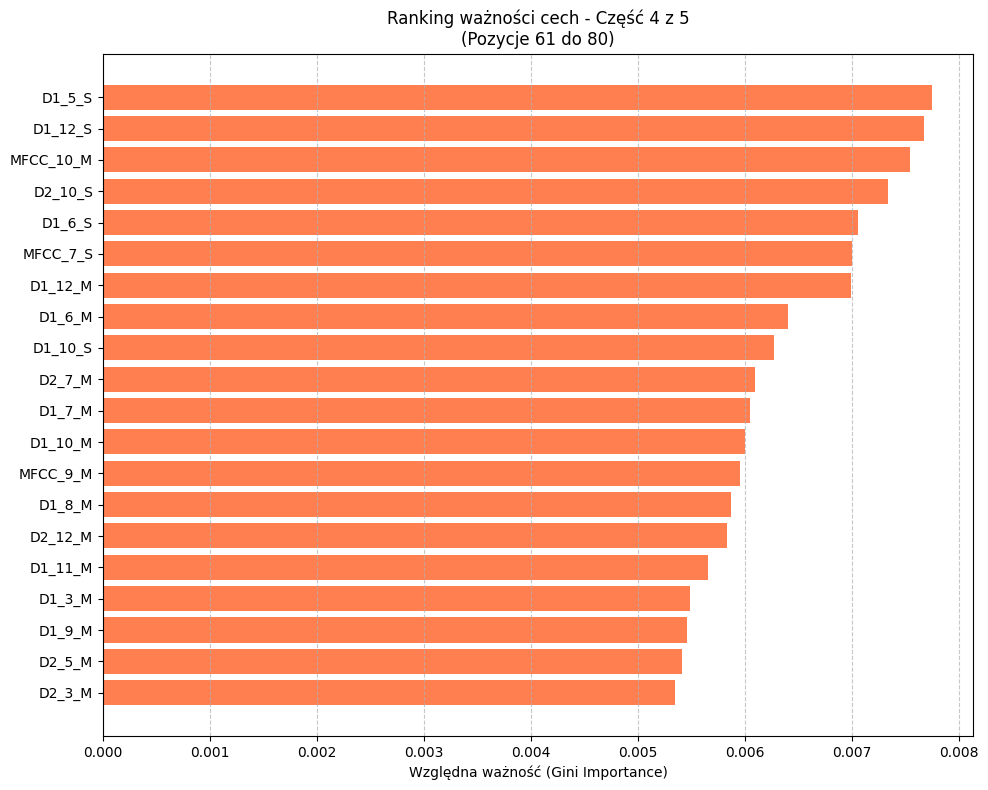

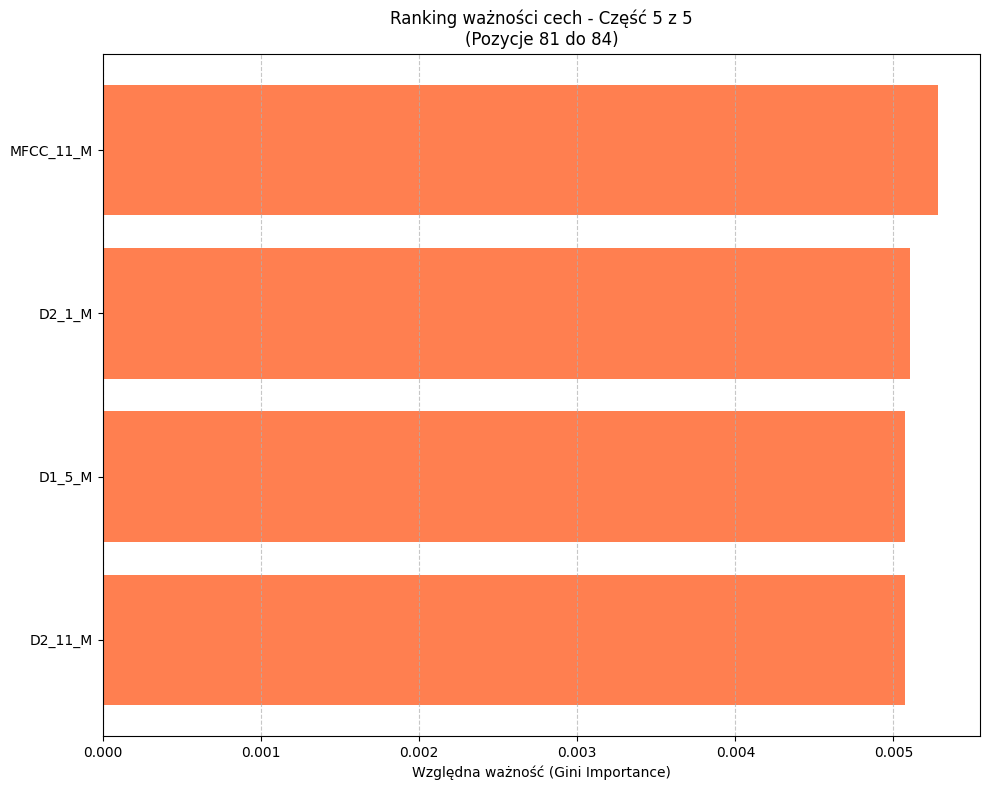

In [4]:
import os
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

# --- Konfiguracja ---
DATA_DIR = '../../dataset/'
N_MFCC = 13 
FEATURES_PER_PLOT = 20

# [Funkcja extract_pro_features pozostaje bez zmian]
def extract_pro_features(file_path, n_mfcc):
    y, sr = librosa.load(file_path, sr=None)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    d = librosa.feature.delta(mfcc)
    d2 = librosa.feature.delta(mfcc, order=2)
    cent = librosa.feature.spectral_centroid(y=y, sr=sr)
    roll = librosa.feature.spectral_rolloff(y=y, sr=sr)
    zcr = librosa.feature.zero_crossing_rate(y)
    return np.concatenate([
        np.mean(mfcc, axis=1), np.std(mfcc, axis=1),
        np.mean(d, axis=1), np.std(d, axis=1),
        np.mean(d2, axis=1), np.std(d2, axis=1),
        [np.mean(cent), np.std(cent), np.mean(roll), np.std(roll), np.mean(zcr), np.std(zcr)]
    ])

# 1. Pobieranie danych (skrócony opis procesu)
X, labels = [], []
classes = [d for d in os.listdir(DATA_DIR) if os.path.isdir(os.path.join(DATA_DIR, d))]
print(f"Przetwarzanie klas: {classes}")

for label in classes:
    class_path = os.path.join(DATA_DIR, label)
    for f in os.listdir(class_path):
        if f.endswith('.wav'):
            X.append(extract_pro_features(os.path.join(class_path, f), N_MFCC))
            labels.append(label)

y = LabelEncoder().fit_transform(labels)
X = np.array(X)

# Generowanie nazw cech
fn = ([f"MFCC_{i}_M" for i in range(N_MFCC)] + [f"MFCC_{i}_S" for i in range(N_MFCC)] +
      [f"D1_{i}_M" for i in range(N_MFCC)] + [f"D1_{i}_S" for i in range(N_MFCC)] +
      [f"D2_{i}_M" for i in range(N_MFCC)] + [f"D2_{i}_S" for i in range(N_MFCC)] +
      ["Cent_M", "Cent_S", "Roll_M", "Roll_S", "ZCR_M", "ZCR_S"])

# 2. Trening modelu
rf = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
rf.fit(X, y)

# 3. Przygotowanie rankingu
importances = rf.feature_importances_
df = pd.DataFrame({'Feature': fn, 'Importance': importances}).sort_values(by='Importance', ascending=False)

# 4. Podział na wiele wykresów (stronowanie)
num_features = len(df)
num_plots = math.ceil(num_features / FEATURES_PER_PLOT)

print(f"Wykryto {num_features} cech. Generowanie {num_plots} wykresów...")

for i in range(num_plots):
    start_idx = i * FEATURES_PER_PLOT
    end_idx = start_idx + FEATURES_PER_PLOT
    subset = df.iloc[start_idx:end_idx]
    
    plt.figure(figsize=(10, 8))
    plt.barh(subset['Feature'], subset['Importance'], color='coral')
    plt.gca().invert_yaxis()
    plt.title(f"Ranking ważności cech - Część {i+1} z {num_plots}\n(Pozycje {start_idx+1} do {min(end_idx, num_features)})")
    plt.xlabel("Względna ważność (Gini Importance)")
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

Obliczanie Permutation Importance...


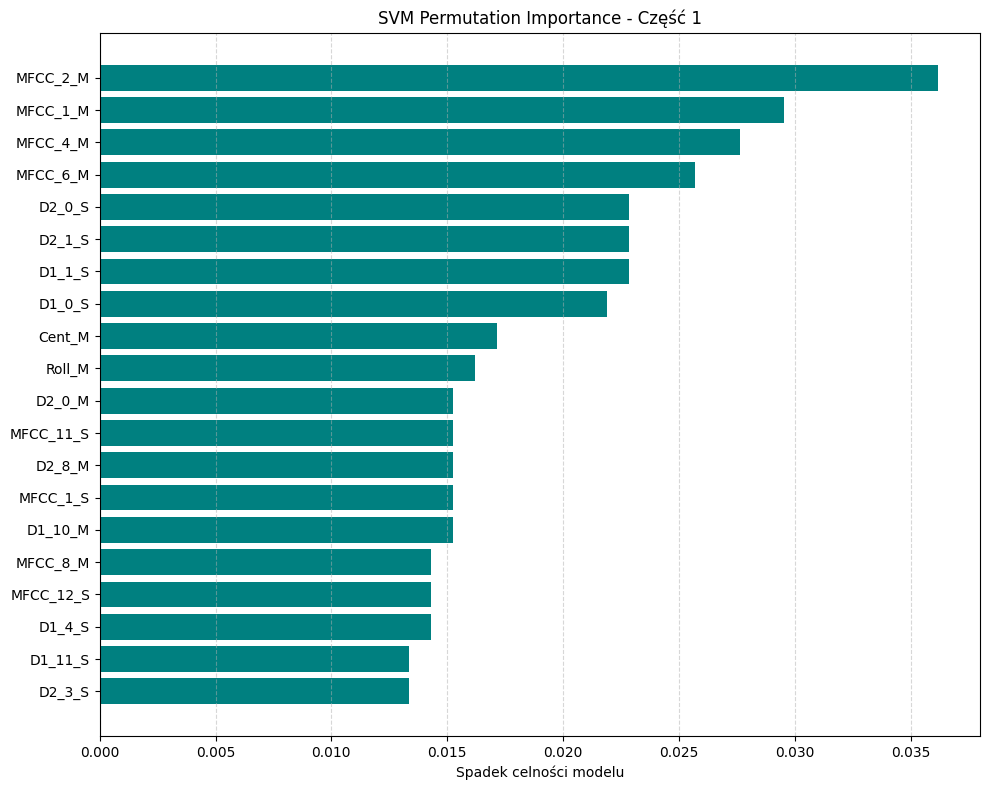

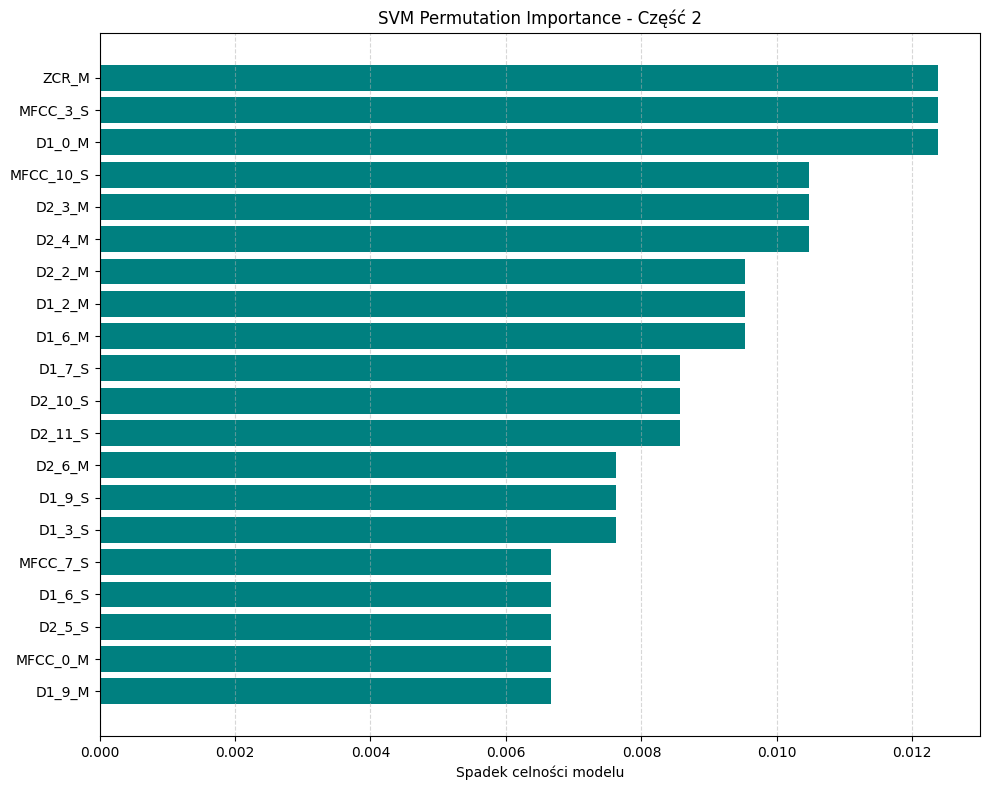

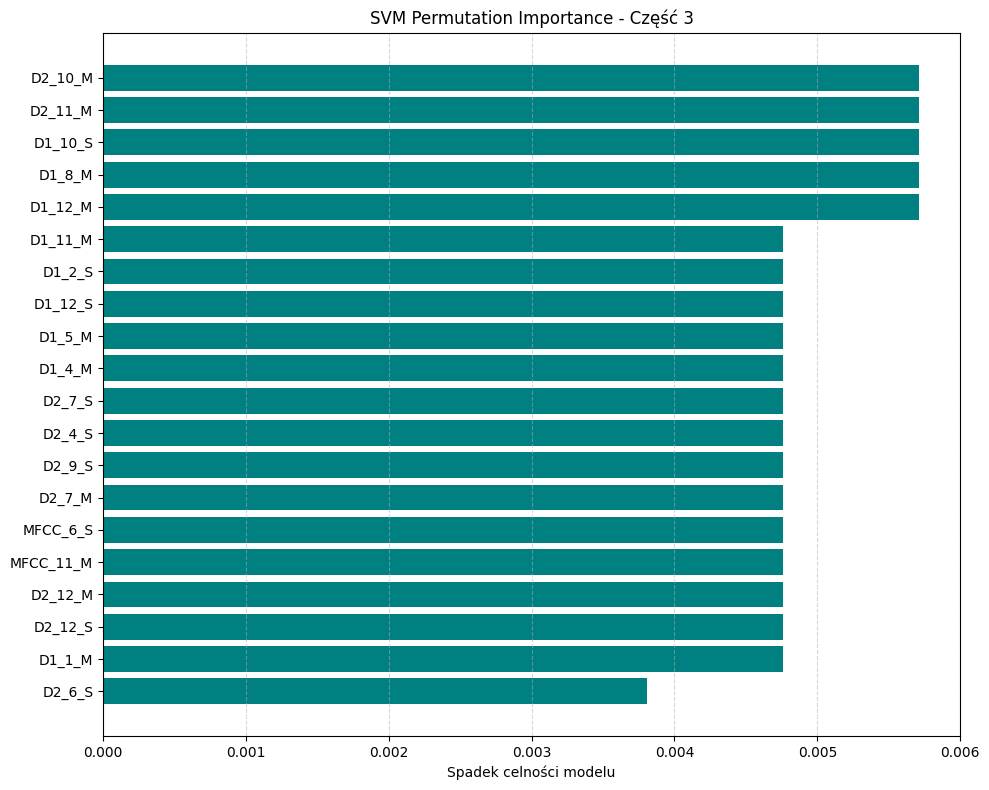

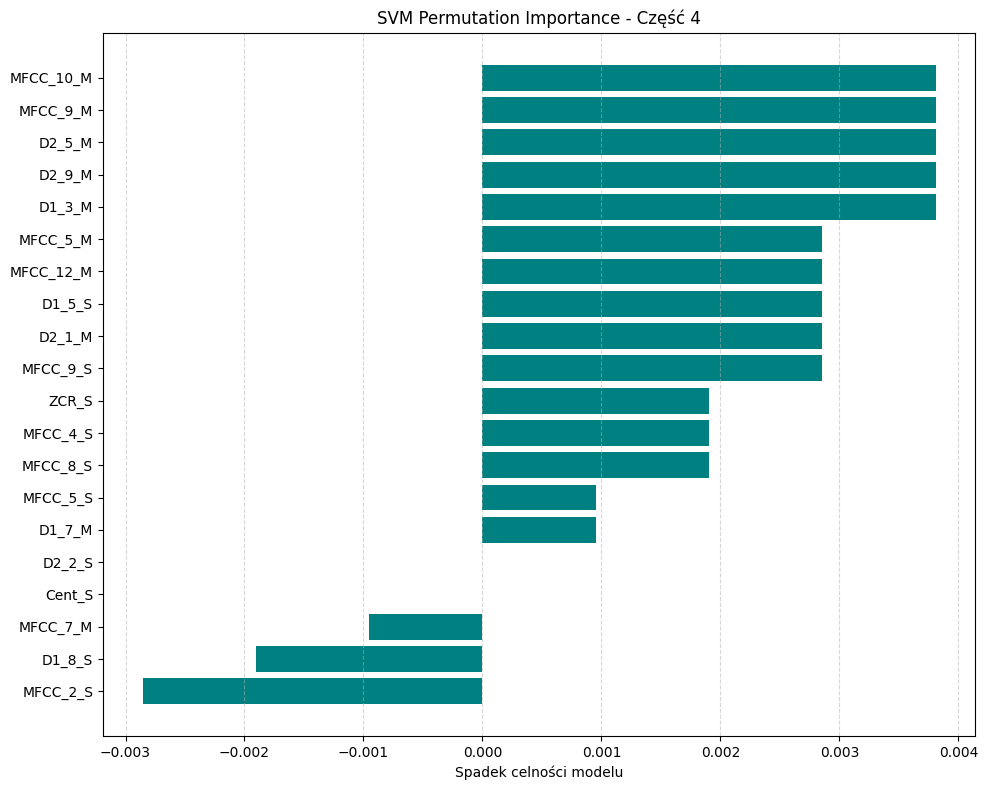

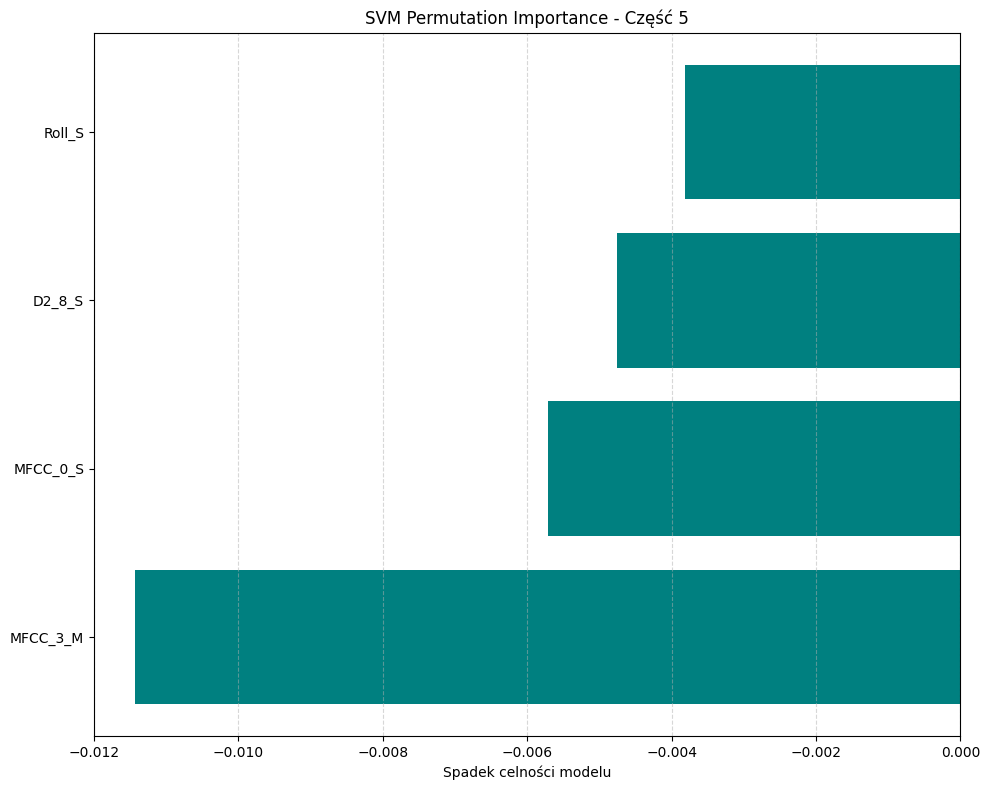

In [5]:
from sklearn.inspection import permutation_importance
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

# [Załóżmy, że X, y i fn są już zdefiniowane jak powyżej]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# 1. Trening modelu SVC
clf = make_pipeline(StandardScaler(), SVC(kernel="rbf", C=1.0))
clf.fit(X_train, y_train)

# 2. Obliczanie ważności
print("Obliczanie Permutation Importance...")
res = permutation_importance(clf, X_test, y_test, n_repeats=5, random_state=42, n_jobs=-1)

# 3. Tworzenie DataFrame
df_perm = pd.DataFrame({'Feature': fn, 'Importance': res.importances_mean}).sort_values(by='Importance', ascending=False)

# 4. Wyświetlanie w częściach
for i in range(math.ceil(len(df_perm) / FEATURES_PER_PLOT)):
    subset = df_perm.iloc[i*FEATURES_PER_PLOT : (i+1)*FEATURES_PER_PLOT]
    
    plt.figure(figsize=(10, 8))
    plt.barh(subset['Feature'], subset['Importance'], color='teal')
    plt.gca().invert_yaxis()
    plt.title(f"SVM Permutation Importance - Część {i+1}")
    plt.xlabel("Spadek celności modelu")
    plt.grid(axis='x', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()